# **Proyecto con RNN y LSTM**
Valeria González Baz


I. Introducción: Arquitecturas de Modelado y Generación de Seno

Existen diversas arquitecturas para diseñar modelos (many-to-one, many-to-many, etc.).
Se generará una señal senoidal controlable, especificando el número de secuencias a generar.
La función de generación del seno incluirá un parámetro para aleatorizar la frecuencia y la fase (desplazamiento) de cada secuencia (ejemplo: generar x secuencias de seno con 100 fases aleatorias).
La primera parte del proceso se centra en la generación de estas señales senoidales.

II. Ejemplo 1: Arquitectura Many-to-One

Objetivo: Predecir un único valor y a partir de una secuencia de múltiples elementos x.
Proceso:
Se utilizan tensores y un DataLoader para manejar los datos.
Se define una red neuronal recurrente (RNN), cuya naturaleza temporal es crucial para la tarea.
La capa de salida de la red se adaptará a la tarea de clasificación (sigmoide o softmax) o regresión.
En la capa forward de la red, es importante definir cuántos elementos se esperan como salida final (en este caso, uno).

Consideración clave: Cómo se extrae la última salida relevante de la secuencia procesada por la RNN.

Entrenamiento y Cálculo del Loss:
Durante el entrenamiento, se compara la predicción de la red con un único valor objetivo y.
Para calcular la función de pérdida (loss), las dimensiones de la predicción y el objetivo deben ser compatibles. En una arquitectura many-to-one, la entrada del objetivo y y la salida de la red deben tener dimensiones consistentes.

III. Ejemplo 2: Arquitectura Many-to-Many

Cálculo del Loss: Al igual que en many-to-one, para calcular la pérdida en arquitecturas many-to-many, las dimensiones de la entrada objetivo y la salida predicha deben coincidir.
Entrenamiento con Sub-Secuencias: Se puede entrenar la red utilizando únicamente los últimos n elementos de la secuencia de entrada (ejemplo: los últimos 5 elementos, -5:), para enfocar el aprendizaje en patrones recientes.

IV. Ejemplo 3: Arquitectura One-to-Many

Estrategia: La forma más sencilla de implementar un one-to-many es transformarlo en un many-to-many.
Implementación: Se puede generar un vector de entrada donde todos los elementos son idénticos. Esta es la estrategia recomendada si las dimensiones resultantes no causan problemas de memoria en la GPU.

V. Comparativa de Modelos RNN

Objetivo: Evaluar el tiempo de entrenamiento del mismo conjunto de datos utilizando diferentes tipos de redes recurrentes:
LSTM (Long Short-Term Memory)
GRU (Gated Recurrent Unit)
RNN (Recurrent Neural Network básica)

Tarea: Investigar funciones o herramientas que permitan medir y comparar los tiempos de entrenamiento de estos modelos.

VI. Ejercicio 1: Generación de Secuencias Aleatorias y Emulación

Función de Generación: La función genera una secuencia de números aleatorios a partir de una semilla inicial. La semilla (x) es el punto de partida, y el resto de la secuencia (y) se genera de forma determinista a partir de ella.

Objetivo: Construir una red neuronal que pueda emular este proceso de generación. Dada una semilla (análoga a una clave pública), la red debe ser capaz de generar la misma secuencia que produciría la función original (análogo a la relación con una clave privada).

Desafío: Esta tarea no es trivial y requiere una red con la capacidad suficiente para aprender la relación compleja entre la semilla y la secuencia generada.
Consideraciones de Diseño:
Número de neuronas por capa.
Número de capas en la red.
Direccionalidad de la red (unidireccional o bidireccional).

VII. Ejercicio 2: Demostración Visual del Decaimiento de Frecuencia

Objetivo: Demostrar visualmente cómo la frecuencia de los primeros valores en una secuencia (generada por algún proceso o modelo previo) tiende a decaer o cambiar con el tiempo.

Implementación: Esto implicará generar los datos necesarios, posiblemente aplicar alguna técnica de análisis de frecuencia (como la Transformada de Fourier), y luego crear una visualización que ilustre el cambio en las componentes de frecuencia a lo largo de la secuencia.

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# **1. Ilustración de las diferentes arquitecturas que pueden implementarse en una red neuronal recurrente**

# **1.1 Many To One**

Vamos a generar secuencias que provienen de un seno y vamos a intentar predecir el siguiente punto. No es una tarea complicada así que debería funcionar sin demasiada dimensionalidad.

En este ejemplo vamos a ilustrar las aquitecturas many to one, many to many soncronizado y many to many no sincronizado

In [ ]:
# 1. Generación de datos

  # Generamos secuencias de valores que corresponden a ondas senoidales con una fase aleatoria y una frecuencia entre 0.5 y 3.0 (atender a frequency)

# Si frequency es un numero genera todas las secuencias a esa frecuencia, si no
# Las frecuencias son aleatorias entre 0.5 y 3.0

def generate_sine_data(seq_length=10, num_samples=1000, frequency=None):
    sequences = []
    targets = []

    for i in range(num_samples):

        phase_shift = np.random.uniform(0, 2 * np.pi)  # Fase aleatoria
        current_frequency = frequency if frequency is not None else np.random.uniform(0.5, 3.0)  # Frecuencia fija o aleatoria

        x_values = np.linspace(0, seq_length, seq_length) * (2 * np.pi * current_frequency / seq_length)  # Ajuste de la frecuencia
        sine_wave = np.sin(x_values + phase_shift)

        sequences.append(sine_wave)
        targets.append(np.sin((seq_length * (2 * np.pi * current_frequency / seq_length)) + phase_shift))

    return np.array(sequences), np.array(targets)

  # Cada frecuencia tiene 100 puntos y nuestro objetivo es predecir el siguiente punto (el valor de la onda en el siguiente paso temporal)

# Crear dataset
seq_length = 100     # numero de elementos en la secuencia
num_samples = 1000  # numero de secuencias
X, y = generate_sine_data(seq_length, num_samples) # generate_sine_data es una función que crea los datos y los divide en secuencias de entrada (x) y valores objetivo (y)

In [ ]:
# Ejemplo: entrada X de 100 valores de la onda senoidal y salida Y como el valor de la onda en el siguiente punto

print(X.shape, y.shape)

(1000, 100) (1000,)


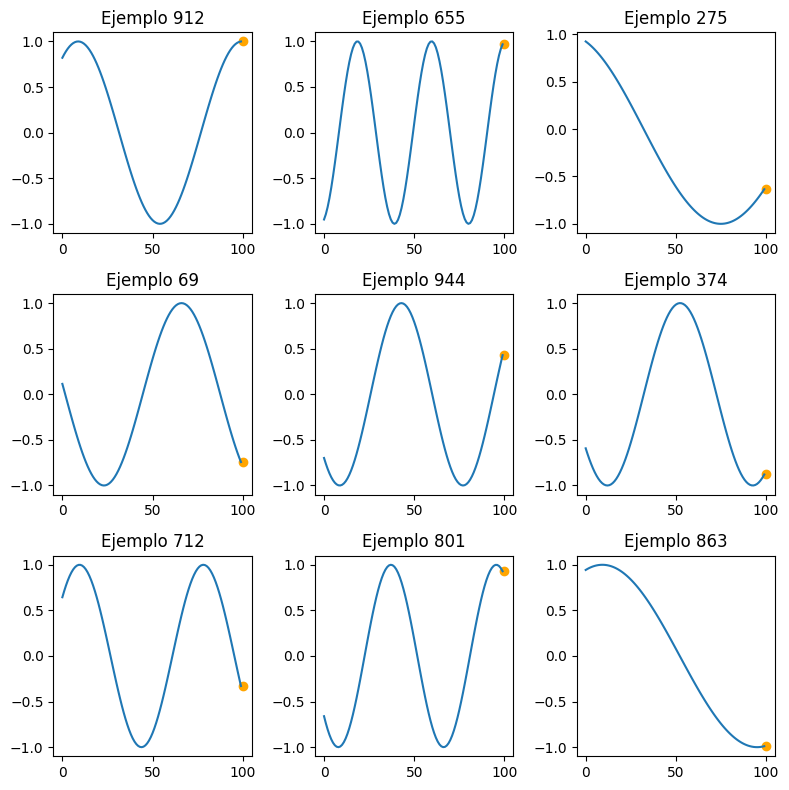

In [ ]:
  # 2. Visualización de los datos

# Generar una matriz de 4x4 plots eligiendo aleatoriamente las secuencias

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
random_indices = np.random.randint(0, num_samples, size=(3, 3))

for i in range(3):
    for j in range(3):
        idx = random_indices[i, j]
        axes[i, j].plot(range(100), X[idx,])
        axes[i, j].scatter(100, y[idx,], color='orange') # se utiliza esto para marcar el valor que queremos predecir (el punto futuro)
        axes[i, j].set_title(f"Ejemplo {idx}")

plt.tight_layout()
plt.show()


In [ ]:
  # 3. Creación del Dataset para PyTorch

# Creamos los tensores y el dataloader

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (samples, seq_length, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # (samples, 1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
  # 4. Definición de la Red Neuronal Recurrente


# fijate que contiene el out, es una matriz de
# out: Este es el tensor de salida de la RNN. Dependiendo de la implementación de la RNN, out tiene la forma [batch_size, seq_len, hidden_size]:


# Definir la RNN
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=1, num_layers=1):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size # 1 neurona en la capa oculta

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1) # capa de integración Z

    def forward(self, x):

        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Una capa totalmente conectada (fc) que toma la última salida de la secuencia (out[:, -1, :]) para predecir un único valor de salida.

        return out

En esta parte de la definición de la RNN debemos prestar especial atención a la sintaxis de python, es decir, al modo de decirle que devuelve el elemento que queramos de la matriz out, del elemento con el que queramos entrenar (dependerá de la arquitectura con la que estemos trabajando). Este paso anterior controla lo que devuelve el forward del modelo, pero tendremos que hacerlo coincidir con la dimensionalidad de Y para poder calcular el la pérdida.



> - Many To One significa que toda la secuencia de 100 puntos se usa para predecir un único valor



In [ ]:
# Inicializar modelo, función de pérdida y optimizador
# Fijate que esto es igual que en MLP

model = RNN()

loss_fn = nn.MSELoss() # usamos MSELoss porque es una tarea de regresión

optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:
# 5.  Entrenar la RNN

epochs = 20 # entrenamos por 20 épocas actualizando los pesos en cada minibatch con backpropagation through time (BPTT)

for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.3638
Epoch 2/20, Loss: 0.0049
Epoch 3/20, Loss: 0.0033
Epoch 4/20, Loss: 0.0034
Epoch 5/20, Loss: 0.0025
Epoch 6/20, Loss: 0.0006
Epoch 7/20, Loss: 0.0024
Epoch 8/20, Loss: 0.0009
Epoch 9/20, Loss: 0.0014
Epoch 10/20, Loss: 0.0008
Epoch 11/20, Loss: 0.0014
Epoch 12/20, Loss: 0.0012
Epoch 13/20, Loss: 0.0003
Epoch 14/20, Loss: 0.0005
Epoch 15/20, Loss: 0.0006
Epoch 16/20, Loss: 0.0004
Epoch 17/20, Loss: 0.0005
Epoch 18/20, Loss: 0.0006
Epoch 19/20, Loss: 0.0004
Epoch 20/20, Loss: 0.0004


In [ ]:

# 6. Evaluación del modelo
# vamos a generar 100 nuevos datos que provienen del mismo generador y ver cuanto acertamos
model.eval()
with torch.no_grad():

    test_X,_ = generate_sine_data(seq_length, 100)  # Generar 100 nuevas secuencias de prueba con la misma función utilizada anteriormente

    test_X_tensor = torch.tensor(test_X, dtype=torch.float32).unsqueeze(-1) # pasamos la nueva data por el modelo en eval () para hacer predicciones sin calculo de gradientes
    test_y = model(test_X_tensor).squeeze().numpy()

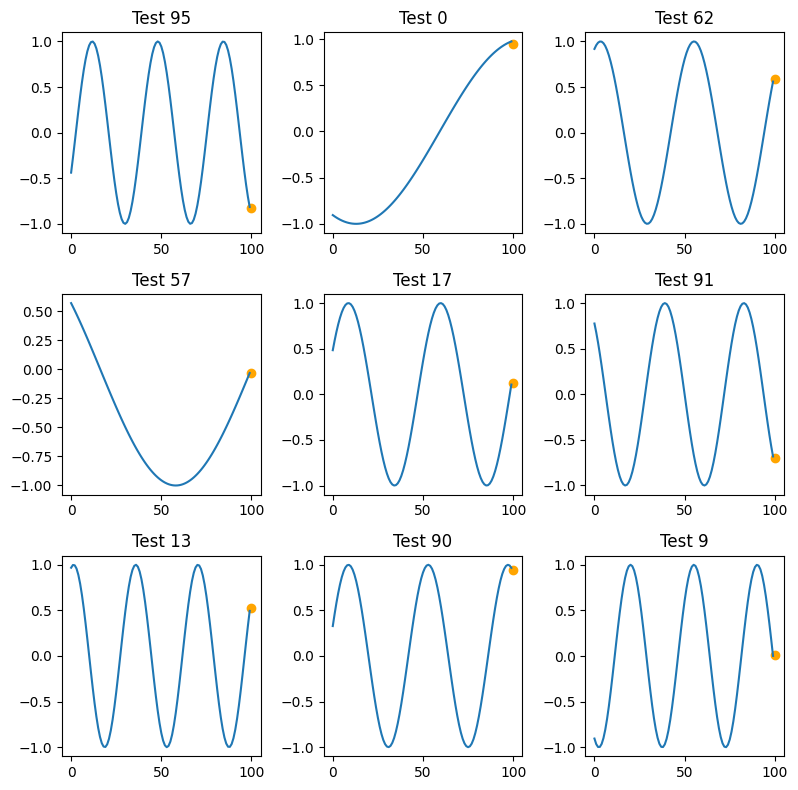

In [ ]:
# 7. Visualización

# Generar una matriz de 3x3 plots eligiendo aleatoriamente las secuencias.
# COmparamos las predicciones con las secuencias reales en graficos de matplotlib

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
random_indices = np.random.randint(0, 100, size=(3, 3))

for i in range(3):
    for j in range(3):
        idx = random_indices[i, j]
        axes[i, j].plot(range(100), test_X[idx,])
        axes[i, j].scatter(100, test_y[idx,], color='orange')
        axes[i, j].set_title(f"Test {idx}")

plt.tight_layout()
plt.show()

Durante todo el ejemplo anterior estamos entrenando una RNN Many-to-One para intentar predecir el siguiente valor de una onda senoidal en 100 valores previos (tarea de serie temporal). Podríamos probar a aumentar el hidden_size para que la red pueda ser capaz de capturar patrones más complejos. Podriamos también probar con una LSTM en lugar de una RNN simple y evitar el desvanecimiento del gradiente aunque en este caso no es estríctamente necesario.

# **1.2. Cambiar la arquitectura del modelo a Many-to-Many sincronizado**

En el modelo anterior la RNN tomaba una secuencia de 100 puntos y solo predecía el siguiente punto (por eso la salida era de tamaño batch_size, 1 y se tomaba sólo la última salida de la RNN -especificada en el out-)

Ahora la RNN tomará la secuencia de 100 puntos y predecirá una secuencia completa de 100 puntos, por lo que, en este caso, la salida ahora es (batch_size, seq_length, 1), o lo que es lo mismo, una predicción para cada punto de la secuencia. Y se compara cada salida con la entrada en cada paso de tiempo (digamos que la red "aprende" a copiar la entrada)



In [ ]:
# 4. Definir la RNN

class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=1, num_layers=1):

        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):

        out, _ = self.rnn(x)
        out = self.fc(out[:, :, :])  # Devolvemos toda la secuencia. No tomamos solo el último paso
        # como anteriormente, aplicamos la capa fc a toda la secuencia, por lo que la red devolverá una predicción por cada entrada
        return out

In [ ]:
# Inicializar modelo, función de pérdida y optimizador
model = RNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:
# 5. Entrenar la RNN

epochs = 20

for epoch in range(epochs):

    for batch_X,_ in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_X) # fijate que usamos como batch_y el propio batch_x
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.4796
Epoch 2/20, Loss: 0.2436
Epoch 3/20, Loss: 0.0180
Epoch 4/20, Loss: 0.0089
Epoch 5/20, Loss: 0.0071
Epoch 6/20, Loss: 0.0052
Epoch 7/20, Loss: 0.0044
Epoch 8/20, Loss: 0.0038
Epoch 9/20, Loss: 0.0028
Epoch 10/20, Loss: 0.0026
Epoch 11/20, Loss: 0.0023
Epoch 12/20, Loss: 0.0019
Epoch 13/20, Loss: 0.0018
Epoch 14/20, Loss: 0.0016
Epoch 15/20, Loss: 0.0014
Epoch 16/20, Loss: 0.0014
Epoch 17/20, Loss: 0.0012
Epoch 18/20, Loss: 0.0011
Epoch 19/20, Loss: 0.0011
Epoch 20/20, Loss: 0.0010


Ahora nuestro objetivo es que la salida sea igual a la entrada (básicamente porque la onda de entrada ya es una onda senoidal perfecta), queremos que la RNN la reproduzca. Por esta razón usamos batch_X como target en la función de pérdida.

In [ ]:
# 6. Evaluación del modelo

model.eval()
with torch.no_grad():
    test_X, test_y = generate_sine_data(seq_length, 100)  # Generar datos de prueba
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32).unsqueeze(-1)
    test_y = model(test_X_tensor).squeeze().numpy()

Aquí generamos nuevas secuencias y se evalúan con el modelo

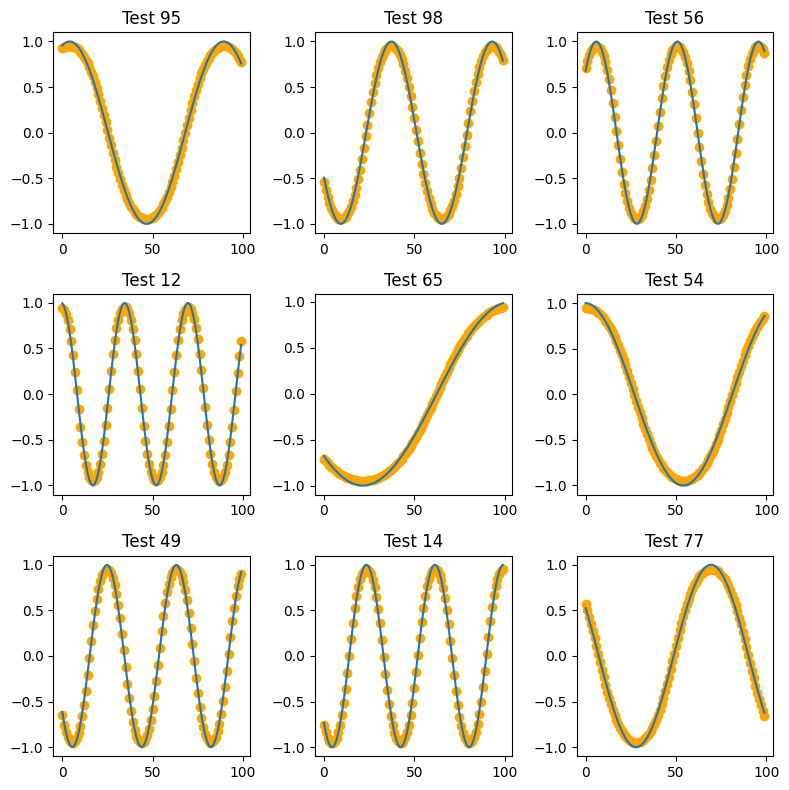

In [ ]:
# 7. Visualización de las predicciones

# Generar una matriz de 3x3 plots eligiendo aleatoriamente las secuencias

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
random_indices = np.random.randint(0, 100, size=(3, 3))

for i in range(3):
    for j in range(3):
        idx = random_indices[i, j]
        axes[i, j].plot(range(100), test_X[idx,])
        axes[i, j].scatter(range(100), test_y[idx,], color='orange')
        axes[i, j].set_title(f"Test {idx}")

plt.tight_layout()
plt.show()

Graficamos las predicciones en color naranja junto con las secuencias reales

# **1.3. Many to Many no Sincronizado**


En esta arquitectura la RNN toma toda la secuencia de entrada pero solo predice los últimos 5 puntos (la diferencia con los anteriores modelos es su salida y el propósito de la arquitectura, como salida tenemos los últimos 5 puntos y el propósito es el de predecir solo parte de la secuencia, no predecir el siguiente paso o aprender a copiar la secuencia)


In [ ]:

# 4. Definir la RNN
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=1, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -5:, :])  # Tomar los últimos 5 puntos de la secuencia
        return out

El punto clave diferente a los modelos anteriores está, de nuevo, en out, ya que seleccionamos solo los últimos 5 valores de la secuencia.

La red aprende de toda la secuencia pero solo necesita hacer predicciones para los últimos 5 puntos.

In [ ]:

# Inicializar modelo, función de pérdida y optimizador

model = RNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:

# 5. Entrenar la RNN

epochs = 20

for epoch in range(epochs):

    for batch_X, _ in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_X[:,-5:,:])
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

En este caso el loss se calcula comparando solo los últmos 5 valores predichos con los valores reales (la RNN usa la memoria de la ecuencia completa para mejorar la precisión en esos 5 valores finales)

In [ ]:

# 6. Evaluación del modelo

model.eval()
with torch.no_grad():
    test_X, test_y = generate_sine_data(seq_length, 100)  # Generar datos de prueba
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32).unsqueeze(-1)
    test_y = model(test_X_tensor).squeeze().numpy()


Generamos nuevas secuencias de prueba que se pasan por el modelo para hacer predicciones en los últimos 5 puntos.

In [ ]:

# Generar una matriz de 3x3 plots eligiendo aleatoriamente las secuencias

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
random_indices = np.random.randint(0, 100, size=(3, 3))

for i in range(3):
    for j in range(3):
        idx = random_indices[i, j]
        axes[i, j].plot(range(100), test_X[idx,])
        axes[i, j].scatter(range(95,100), test_y[idx,], color='orange')
        axes[i, j].set_title(f"Test {idx}")

plt.tight_layout()
plt.show()

De nuevo, visualizamos los puntos naranjas que representan las predicciones para los últimos 5 puntos de la onda

La RNN ha aprendido de toda la secuencia pero solo predice los últimos 5 valores (esto nos sirve para predecir solo la parte final de una serie temporal)

# **1.4. One to Many**

En este caso la red recibe una sola entrada y genera una secuencia completa basada en esa entrada (generar una serie temporal a partir de un solo punto inicial, por ejemplo, generación de texto).

¿Como implementamos este cambio en el código?:

In [ ]:
def forward(self, x):

    # x tiene forma [batch_size, 1, input_size] (una única entrada)
    x = x.repeat(1, self.seq_len, 1)  # Expande la entrada a toda la secuencia


Repeat repite la entrada x a lo largo de la dmensión de la secuencia, si por ejemplo seq_len fuese igual a 10 enotnces la misma entrada se repite 10 veces para qe la RNN pueda generar 10 valores de salida.

- La entrada X es un único valor por cada muestra en el batch.
- La salida Y es una secuencia completa de valores esperados.
-  La pérdida se calcula comparando la secuencia generada con la secuencia real.

In [ ]:
loss = loss_fn(predictions, batch_Y)  # batch_Y contiene la secuencia esperada

Las Redes Neuronales Recurrentes al estar diseñadas para trabajar con secuencias de datos superan la limitación de las redes neuronales tradicionales (como los MLP), ya que tienen una memoria interna que es lo que permite recordar información de entradas anteriores. El desvanecimiento del gradiente es la limitación que presentan las RNN (si la secuencia de datos es larga, la info del pasado tenderá a desvanecerse). Y para esto es para lo que se desarrollaron dos arquitecturas, LSTM y GRU (versión simplificada).

Cuadno trabajamos con estas estructuras tenemos que considerar cuantas variables de entrada tendremos (matriz de datos), si necesitamos capas apiladas (num_layers > 1) para más profundidad y si el modelo debe aprender en ambas direcciones (bidirectional =True). Elegir el modelo parte por tener muy claro nuestro objetvo y cuales son las necesidades temporales que tenemos.

# **Ejercicio 01.**

**Nuestro objetvo:** Descubrir la ecuación generadora de Python.


Los generadores de números aleatorios como el que utiliza nunmpy (que se basa en el algoritmo Mersenne Twister, https://github.com/boo1ean/mersenne-twister/blob/master/README.md ,https://github.com/ESultanik/mtwister/blob/master/mtwister.c) no genera números "aleatorios" estrictamente, porque toman una semilla y se usa una serie de operaciones para calcular el sigiente número de la secuencia, siendo esta semilla como una especie de clave para inicializar el proceso.

Por ejemplo, una vez puesta la primera semilla se le aplican ciertas operaciones matematicas deterministas para obtener un numero, luego se usa ese número para generar el siguiente, y así de forma sucesiva creando una secuencia de números.

La semilla es un número entero de longitud fija, y el tamaño depende del tipo de generador que estemos usando (en python con numpy la semilla suele ser de un numero entero de 32 o 64 bits -cantidad de dígitos binarios-). Que la semilla sea de 32 bits quiere decir que (a parte que es un numero entero que ocupa 32 bits de memoria) este número puede ser cualquier valor entre 0 y 2^32-1, más de 4 mil millones de valores diferentes.

La semilla puede ser cualquier número entero dentro del rango. Si no proporcionamos una semilla específica entonces genera una semilla "aleatoria" y numpy usa la hora actual del sistema o alguna fuente que cambia constantemente como valor predeterminado, por eso "aleatorio". También le podemos dar un valor específico fijando la semilla, y siempre generará la misma secuencia de números aleatorios cada vez que se ejecute el código (la semilla se puede establecer a un número fijo o no).

La semilla es una especie de clave para su generador determinista que cálcula números a partir de esa semilla.

Por todo esto, lo que buscamos hacer es descubrir esta función generadora que a partir de una semilla específica genera una secuencia de números aleatorios. Este proceso es "secreto" porque depende de la implementación interna de Python.

**¿Cuál es aquí el desafío?:** Dado que la semilla es conocida nuestro reto es usarla para predecir la secuencia de números generada por el generador de Python. Por esto es útil usar estos modelos de redes recurrentes, porqe aprenden patrones temporales como las secuencias de núeros generadas a partir de una semilla.

Queremos que el modelo aprenda cómo la semilla influye en la secuencia y a partir de eso predecir la secuencia futura o la secuencia completa solo conociendo la semilla (a partir de nuestros inputs -x- que serán las semillas, y los outputs -y- que serán las secuencias)

Dependiendo de cómo queramos modelar la relación entre la semilla y la secuencia generada podríamos optar por unas arquitecturas u otras. Para este caso voy a optar por **many to many sincronizado**, ya que quiero mapear una entrada a una salida y de esta forma podremos enseñar al modelo a generar todas las salidas de manera coherente respecto a la entrada.

**¿Realmente necesitaríamos aquí el uso de LSTM o GRU?** El número que se genera no depende de los números anteriores en la secuencia (cada número es independiente de los anteriores). La secuencia completa de números solo es una consecuencia de la semilla inicial y cada número se genera de forma independiente (aunque está correlacionado por la semilla, no por los números anteriores). Por esta razón estrictamente no tenemos por qué necesitar una LSTM/GRU, porque no nos afecta el problema del descenso del gradiente.
Podemos probarlo de todos modos, ya que son arquitecturas que pueden captar patrones incluso sutiles en el espacio de generación de secuencias (incluso sin una clara dependencia temporal entre los elementos de la secuencia).

Vamos a probar el enfoque many to many sincronizado:

In [ ]:
  # 1. Generamos las semillas y secuencias aleatorias

import numpy as np

def generate_random_vectors(num_vectors=1000, num_seq=10):

    seeds = [] # En esta lsta almacenamos las semillas generadas
    vectors = [] # Almacenamos las secuencias generadas

    for i in range(num_vectors): # Repetimos el proceso (iteramos) para num_vector veces

        seed = np.random.randint(0, 2**32)  # Generamos una semilla aleatoria entre 0 y 2^32-1

        seeds.append(seed) # Guardamos la semilla generada

        np.random.seed(seed)  # Fijamos la semilla como la semilla global para la generación de números aleatorios

        vector = np.random.rand(num_seq)  # Generamos la secuencia de 10 números aleatorios (de longitud num_seq)

        vectors.append(vector) # Guardamos la secuencia generada


    return np.array(seeds), np.array(vectors) # Devolvemos las semillas y las secuencias como arrays de numpy


# Obtenemos las semillas y secuencias (con un nombre claro para X e Y)
semillasX, secuenciasY = generate_random_vectors()

**2. Creación del modelo RNN**

Vamos a crear el modelo para predecir la secuencia basada en la semilla

In [ ]:
# 2. Convertir datos a tensores

import torch
from torch.utils.data import DataLoader, TensorDataset

# 2.1. Normalización de las semillas

# Normalizar las semillas dividiéndolas por su valor máximo .
  # Tenemos que normalizar las semillas porque son números enteros muy grandes (de 0 a 2^32-1), tenemos que normalizarlo porque es mucho más grande que los valores de salida, y esto podría dificultar a la red un aprendizaje correcto.
semillasX_norm = semillasX / (2**32 - 1)

# Las Y no las normalizamos porque ya están en un rango manejable para la red [0,1], normalizarlo solo haría cambiar su distribución


from sklearn.model_selection import train_test_split

# 2. 3. Dividir los datos en conjuntos de entrenamiento y prueba
semillas_train, semillas_test, secuencias_train, secuencias_test = train_test_split(semillasX_norm, secuenciasY, test_size=0.2, random_state=42)


# 2. 4. Crear tensores y dataloaders para entrenamiento y prueba

# 2.4.1 Entrenamiento
semillas_train_tensor = torch.tensor(semillas_train, dtype=torch.float32).unsqueeze(-1)
secuencias_train_tensor = torch.tensor(secuencias_train, dtype=torch.float32).unsqueeze(-1)
train_dataset = TensorDataset(semillas_train_tensor, secuencias_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2.4.2 Prueba
semillas_test_tensor = torch.tensor(semillas_test, dtype=torch.float32).unsqueeze(-1)
secuencias_test_tensor = torch.tensor(secuencias_test, dtype=torch.float32).unsqueeze(-1)



In [ ]:
print(f"Media de semillas: {semillas_train_tensor.mean().item():.4f}, Desv. estándar: {semillas_train_tensor.std().item():.4f}")
print(f"Media de secuencias: {secuencias_train_tensor.mean().item():.4f}, Desv. estándar: {secuencias_train_tensor.std().item():.4f}")


Media de semillas: 0.5006, Desv. estándar: 0.2879
Media de secuencias: 0.5078, Desv. estándar: 0.2883


Las secuencias de salida se generan con np.random.rand que produce numeros aleatorios en el rango [0, 1], por eso las secuencias ya están en un rango manejable para la red, porque los valores están limitados a ese rango. Esta es la razón por la que no he normalizado las salidas. Al entrenar el modelo por primera vez con una red RNN muy simple no solo es que las predicciones sean pésimas, sino que todas las secuencias de los 10 números de salida están todos alrededor de 0.5, aunque el MSE y el MAE son muy bajos. Aunque esto podría deberese a diferentes explicaciones (*todo esto está mejor comentado al final del ejercicio*), es posible que el modelo no esté aprendiendo patrones complejos y que simplemente esté encontrado una solución trivial que minimiza el error (quizá pueda tener que ver con la normalización de la secuencia de los datos?)





In [ ]:
print("Forma de semillas tensor (entrada al modelo):", semillas_train_tensor.shape)
print("Forma de secuencias tensor (etiquetas reales):", secuencias_train_tensor.shape)

print("\nEjemplo de datos de entrada:")
print(semillas_train_tensor[:3])  # Vemos 3 ejemplos de entrada
print("\nEjemplo de etiquetas reales:")
print(secuencias_train_tensor[:3])  # Vemos 3 secuencias reales


Forma de semillas tensor (entrada al modelo): torch.Size([800, 1])
Forma de secuencias tensor (etiquetas reales): torch.Size([800, 10, 1])

Ejemplo de datos de entrada:
tensor([[0.1754],
        [0.3859],
        [0.6568]])

Ejemplo de etiquetas reales:
tensor([[[0.7348],
         [0.2465],
         [0.9335],
         [0.8891],
         [0.0684],
         [0.4031],
         [0.3494],
         [0.9050],
         [0.5714],
         [0.3323]],

        [[0.2026],
         [0.3422],
         [0.7111],
         [0.2942],
         [0.9553],
         [0.8727],
         [0.1813],
         [0.2558],
         [0.6626],
         [0.6529]],

        [[0.7122],
         [0.0450],
         [0.5857],
         [0.4900],
         [0.9492],
         [0.1623],
         [0.7928],
         [0.6268],
         [0.7819],
         [0.3739]]])


In [ ]:
print(len(train_dataloader.dataset))


800


El dataset tiene 1000 ejemplos en total (*ESTE COMENTARIO ES ANTES DE LA PARTICIÓN DEL CONJUNTO EN TRAIN Y TEST*) , teniendo un batch size de 32, obtendriamos 31.25 batches (1000/32), esto quiere decir que el último batch tendrá solo 8 ejemplos (1000 - (31/times32) = 8). Por eso luego veremos un batch de tamaño 8, porque este último tiene menos datos.

Si metemos este codigo: drop_last=True, podríamos descartar el último trozo de batch si es más pequeño.

**Confirmación de que el datset no es múltiplo de 32:**

In [ ]:
for i, (batch_semillas, batch_secuencias) in enumerate(train_dataloader):
    print(f"Batch {i+1}: {batch_semillas.shape}")


Batch 1: torch.Size([32, 1])
Batch 2: torch.Size([32, 1])
Batch 3: torch.Size([32, 1])
Batch 4: torch.Size([32, 1])
Batch 5: torch.Size([32, 1])
Batch 6: torch.Size([32, 1])
Batch 7: torch.Size([32, 1])
Batch 8: torch.Size([32, 1])
Batch 9: torch.Size([32, 1])
Batch 10: torch.Size([32, 1])
Batch 11: torch.Size([32, 1])
Batch 12: torch.Size([32, 1])
Batch 13: torch.Size([32, 1])
Batch 14: torch.Size([32, 1])
Batch 15: torch.Size([32, 1])
Batch 16: torch.Size([32, 1])
Batch 17: torch.Size([32, 1])
Batch 18: torch.Size([32, 1])
Batch 19: torch.Size([32, 1])
Batch 20: torch.Size([32, 1])
Batch 21: torch.Size([32, 1])
Batch 22: torch.Size([32, 1])
Batch 23: torch.Size([32, 1])
Batch 24: torch.Size([32, 1])
Batch 25: torch.Size([32, 1])


In [ ]:
# 3.  Definición del modelo Many-to-Many Sincronizado
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=2): #hidden_size=16, número de neuronas en la capa oculta, el valor dependerá de la complejidad de la tarea
     # num_layers = 2 son las capas apiladas (tener en cuenta los recursos computacionales y el riesgo de overfitting)

        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Salida con 1 valores (num_seq)

    def forward(self, x):

        x = x.unsqueeze(1).repeat(1, 10, 1)  # Expandimos la semilla a 10 pasos de tiempo. Repetimos la entrada seq_len veces. Repetimos la semilla (el valor de entrada) para que ajuste a la longitud de la secuencia
        out, _ = self.rnn(x)  # Procesamos la entrada en la RNN
        out = self.fc(out)  # Devolvemos toda la secuencia [:, :, :]
        return out


In [ ]:
# 3.1 SEGUNDA PRUEBA: Definición del modelo Many-to-Many Sincronizado

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, dropout_rate=0.3):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)  # Cambiado a LSTM
        self.fc = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()  # Agregamos ReLU para evitar que los valores sean demasiado similares


    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 10, 1)
        out, _ = self.lstm(x)
        out = self.fc(out)
        return self.relu(out)


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=3, dropout_rate=0.2):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 10)  # 10 salidas en vez de 1

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)  # Mapea la salida de LSTM a 10 valores por secuencia
        return out


Para intentar resolver el problema:
https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.ipynb

In [ ]:
# 3.2. TERCERA PRUEBA (usar transformers porque igual la relación entre la semilla y la secuencia no es estrictamente una relación temporal)

from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torch.nn as nn

class TransformerModel(nn.Module):

    def __init__(self, input_size=1, hidden_size=64, num_layers=3, output_size=10):

        super(TransformerModel, self).__init__()
        encoder_layers = TransformerEncoderLayer(d_model=hidden_size, nhead=4)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.transformer_encoder(x)
        out = self.fc(out[:, -1, :])
        return out

model = TransformerModel()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# 4.  Inicialización del modelo, función de pérdida y optimizador
import torch.optim as optim
model = RNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005) # en la primera prueba estaba a 0.01

In [ ]:
# 4.  Inicialización del modelo, función de pérdida y optimizador
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # en la primera prueba estaba a 0.01

In [ ]:
# 5.  Entrenamiento de la RNN

epochs = 20


for epoch in range(epochs):

    total_loss = 0  # Para acumular la pérdida total de la epoch
    num_batches = 0  # Para contar el número de batches


    for batch_semillas, batch_secuencias in train_dataloader:

        optimizer.zero_grad()
        predictions = model(batch_semillas)

        loss = loss_fn(predictions, batch_secuencias)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Acumular pérdida
        num_batches += 1  # Contar batches

    # Calcular MSE promedio por epoch
    mse_epoch = total_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs}, MSE: {mse_epoch:.4f}")


    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


print("Entrenamiento finalizado.")

print("Forma de predictions:", predictions.shape)
print("Forma de batch_secuencias:", batch_secuencias.shape)


Epoch 1/20, MSE: 0.1599
Epoch 1/20, Loss: 0.0931
Epoch 2/20, MSE: 0.1037
Epoch 2/20, Loss: 0.1021
Epoch 3/20, MSE: 0.0960
Epoch 3/20, Loss: 0.1039
Epoch 4/20, MSE: 0.0920
Epoch 4/20, Loss: 0.0920
Epoch 5/20, MSE: 0.0898
Epoch 5/20, Loss: 0.0850
Epoch 6/20, MSE: 0.0879
Epoch 6/20, Loss: 0.0923
Epoch 7/20, MSE: 0.0860
Epoch 7/20, Loss: 0.0829
Epoch 8/20, MSE: 0.0849
Epoch 8/20, Loss: 0.0855
Epoch 9/20, MSE: 0.0841
Epoch 9/20, Loss: 0.0795
Epoch 10/20, MSE: 0.0840
Epoch 10/20, Loss: 0.0846
Epoch 11/20, MSE: 0.0837
Epoch 11/20, Loss: 0.0797
Epoch 12/20, MSE: 0.0832
Epoch 12/20, Loss: 0.0910
Epoch 13/20, MSE: 0.0836
Epoch 13/20, Loss: 0.0863
Epoch 14/20, MSE: 0.0836
Epoch 14/20, Loss: 0.0868
Epoch 15/20, MSE: 0.0833
Epoch 15/20, Loss: 0.0855
Epoch 16/20, MSE: 0.0834
Epoch 16/20, Loss: 0.0770
Epoch 17/20, MSE: 0.0832
Epoch 17/20, Loss: 0.0846
Epoch 18/20, MSE: 0.0834
Epoch 18/20, Loss: 0.0880
Epoch 19/20, MSE: 0.0833
Epoch 19/20, Loss: 0.0838
Epoch 20/20, MSE: 0.0833
Epoch 20/20, Loss: 0.083

In [ ]:
# 6.  Evaluación del modelo

model.eval()
with torch.no_grad():

    prediccionesY = model(semillas_test_tensor).squeeze().numpy()
    test_secuenciasY = secuencias_test_tensor.numpy()

    print("Ejemplo de predicciones:")
    print(prediccionesY[:3])  # Imprime las primeras 3 predicciones

    print("Primera predicción en entrenamiento:", prediccionesY[0])
    print("Secuencia real en entrenamiento:", test_secuenciasY[0])


Ejemplo de predicciones:
[[0.53012663 0.5286512  0.5162576  0.513566   0.5159545  0.5184911
  0.5199756  0.5206681  0.5209648  0.5210944 ]
 [0.5295563  0.5284193  0.51602614 0.51332325 0.51570445 0.51823777
  0.51971954 0.5204096  0.5207043  0.5208325 ]
 [0.5293954  0.5283538  0.51596075 0.51325464 0.5156339  0.5181662
  0.51964724 0.52033657 0.5206307  0.52075845]]
Primera predicción en entrenamiento: [0.53012663 0.5286512  0.5162576  0.513566   0.5159545  0.5184911
 0.5199756  0.5206681  0.5209648  0.5210944 ]
Secuencia real en entrenamiento: [[0.7914099 ]
 [0.62541854]
 [0.77644205]
 [0.5430024 ]
 [0.95457965]
 [0.57200944]
 [0.7727282 ]
 [0.16940862]
 [0.21122898]
 [0.6389199 ]]


In [ ]:
# Es lo mismo (la evaluación del modelo) pero intentando que nos de cuales serian las primeras 5 predcciones y las reales
from sklearn.metrics import mean_squared_error, mean_absolute_error


model.eval()

with torch.no_grad():

    prediccionesY = model(semillas_test_tensor).squeeze().numpy()  # Usar semillas_test_tensor
    test_secuenciasY = secuencias_test_tensor.numpy()  # Usar secuencias_test_tensor

    print("Ejemplo de predicciones:")
    print(prediccionesY[:5])  # Imprime las primeras 5 predicciones

    print("\nEjemplo de secuencias reales:")
    print(test_secuenciasY[:5])  # Imprime las primeras 5 secuencias reales

    # Calcular MSE y MAE
    mse = mean_squared_error(test_secuenciasY.flatten(), prediccionesY.flatten())
    mae = mean_absolute_error(test_secuenciasY.flatten(), prediccionesY.flatten())

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")


Ejemplo de predicciones:
[[0.53012663 0.5286512  0.5162576  0.513566   0.5159545  0.5184911
  0.5199756  0.5206681  0.5209648  0.5210944 ]
 [0.5295563  0.5284193  0.51602614 0.51332325 0.51570445 0.51823777
  0.51971954 0.5204096  0.5207043  0.5208325 ]
 [0.5293954  0.5283538  0.51596075 0.51325464 0.5156339  0.5181662
  0.51964724 0.52033657 0.5206307  0.52075845]
 [0.5244769  0.5263193  0.5139455  0.5111404  0.51345474 0.5159565
  0.5174145  0.5180829  0.5183598  0.51847476]
 [0.532701   0.5296878  0.5172971  0.5146564  0.5170766  0.5196282
  0.52112466 0.52182806 0.52213377 0.52227   ]]

Ejemplo de secuencias reales:
[[[0.7914099 ]
  [0.62541854]
  [0.77644205]
  [0.5430024 ]
  [0.95457965]
  [0.57200944]
  [0.7727282 ]
  [0.16940862]
  [0.21122898]
  [0.6389199 ]]

 [[0.9003577 ]
  [0.12327949]
  [0.42631137]
  [0.32701924]
  [0.52481294]
  [0.15867695]
  [0.6722385 ]
  [0.3756923 ]
  [0.64711785]
  [0.7607842 ]]

 [[0.15740386]
  [0.9913818 ]
  [0.37897265]
  [0.4700036 ]
  [0.849

In [ ]:

 # Revisamos algunos valores
print("Ejemplo de secuencia real:")
print(secuencias_test_tensor[0].numpy())  # Primera secuencia real
#necesito .numpy() porque secuencias_test_tensor es un tensor de pytorch

print("\nEjemplo de secuencia predicha:")
print(prediccionesY[0].flatten())  # Primera secuencia predicha

Ejemplo de secuencia real:
[[0.7914099 ]
 [0.62541854]
 [0.77644205]
 [0.5430024 ]
 [0.95457965]
 [0.57200944]
 [0.7727282 ]
 [0.16940862]
 [0.21122898]
 [0.6389199 ]]

Ejemplo de secuencia predicha:
[0.53012663 0.5286512  0.5162576  0.513566   0.5159545  0.5184911
 0.5199756  0.5206681  0.5209648  0.5210944 ]


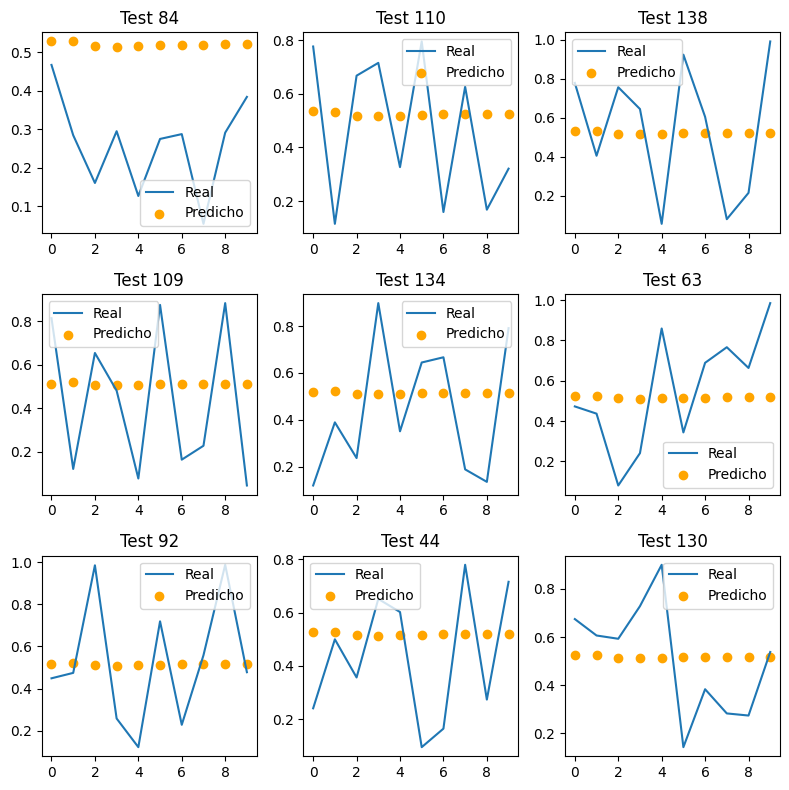

In [ ]:
# 7. Visualización de resultados
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
random_indices = np.random.randint(0, len(secuencias_test_tensor), size=(3, 3))

for i in range(3):
    for j in range(3):
        idx = random_indices[i, j]
        axes[i, j].plot(range(10), secuencias_test_tensor[idx], label="Real")
        axes[i, j].scatter(range(10), prediccionesY[idx].flatten(), color='orange', label="Predicho")
        axes[i, j].set_title(f"Test {idx}")
        axes[i, j].legend()

plt.tight_layout()
plt.show()

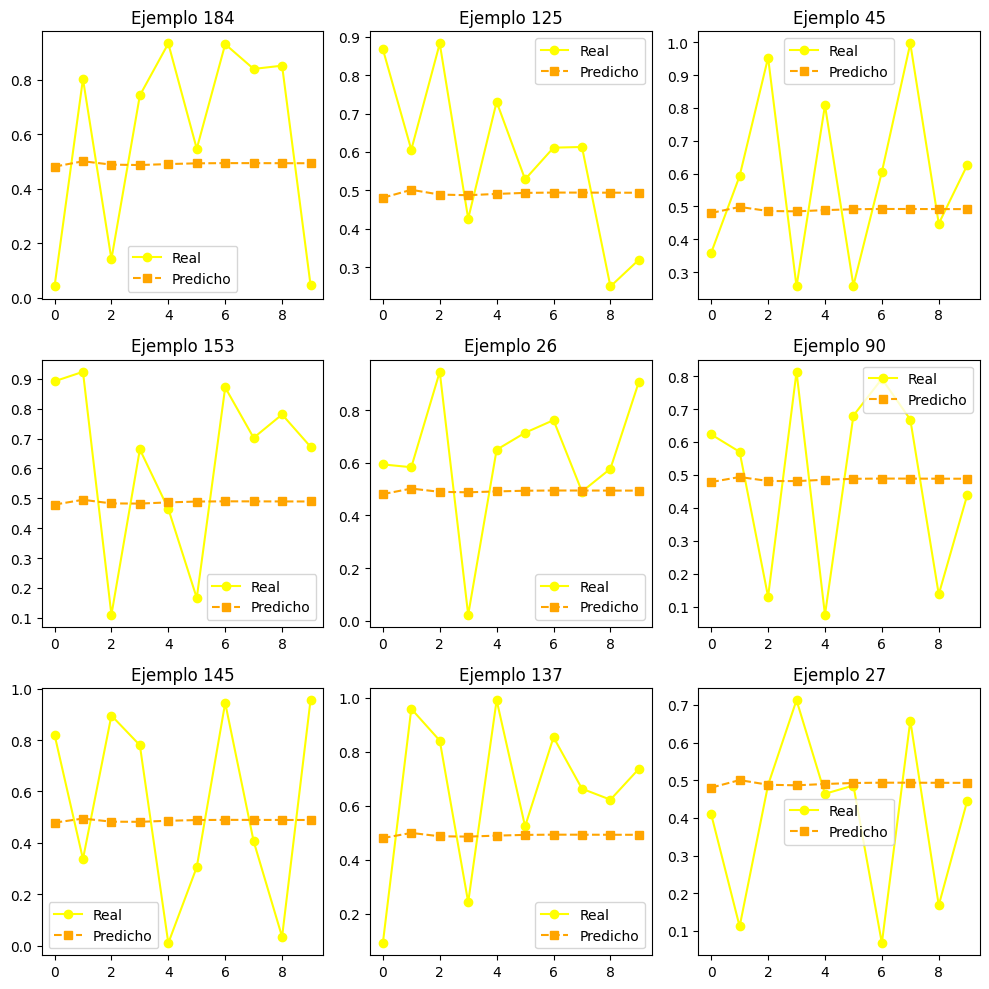

In [ ]:
# Elegimos algunos índices aleatorios
random_indices = np.random.choice(len(secuencias_test_tensor), size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, idx in enumerate(random_indices):
    ax = axes[i // 3, i % 3]

    ax.plot(range(10), secuencias_test_tensor[idx], label="Real", linestyle="-", marker="o", color="yellow")
    ax.plot(range(10), prediccionesY[idx].flatten(), label="Predicho", linestyle="--", marker="s", color="orange")

    ax.set_title(f"Ejemplo {idx}")
    ax.legend()

plt.tight_layout()
plt.show()

En un primer intento , utilizando una RNN simple, 16 capas ocultas y 2 layers appilados no hemos conseguido absolutamente nada. A partir de aqui, comenzaremos a complejizar el modelo para que capture mejor las relaciones entre la semilla y la secuencia generada (más capas ocultas o neuronas en cada capa), meteremos dropout para prevenir overfitting. En un primer momento pensé que quizá no era tan necesario recordar indormación de la semilla, ya que está se repite en cada paso de tiempo en mi arquitectura many to many sincronizado. Sin embargo, no me estaba dando cuenta de que lo que tenemos es una caja negra que transforma una entrada en una salida y aunque la entrada se repite en cada paso de tiempo, no sabemos realmente que operaciones internas complejas puede estar haciendo la caja negra, por eso quizá el uso de LSTM o GRU pueda ayudar a la red a "entender" mejor la estructura interna de la semilla (si la relación entre la semilla y la secuenica de números aleatorios fuese relativamente simple y no hubiese dependencias ocultas probablemente no harían falta estás arquitecturas, pero ya se ha demostrado que no es así)


# **Prueba 02**

Usando redes RNN y LSTM pon un ejemplo en el que se compruebe como en las RNN los estados inciales dejan de influir en la predicción final si la secuencia es larga y como eso se resuelve usando una LSTM

Objetivo: demostrar cómo las RNN pueden sufrir el problema del desvanecimiento del gradiente en secuencias largas, y como una LSTM puede reducir este problema

Como ejemplo para probar esto vamos a predecir la siguiente palabra en una secuencia de texto, donde crearemos dos modelos, no con una RNN simple y otro con una LSTM para entrenar ambos modelos para predecir la siguiente palabra en una secuencia dadas las palabras anteriores.

Esperamos ver cómo la RNN pierde precisión en secuencias largas mientras que la LSTM mantiene mejor rendimiento al recordar el contexto más a largo plazo, gracias a la celda de memoria.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

https://huggingface.co/datasets/karpathy/tiny_shakespeare

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU está disponible y en funcionamiento.")
    print("Nombre del dispositivo:", torch.cuda.get_device_name(0))
else:
    print("GPU no está disponible. Se usará la CPU.")

GPU está disponible y en funcionamiento.
Nombre del dispositivo: Tesla T4


In [ ]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# 1. Cargar y preprocesar el dataset
import torch
import torch.nn as nn
import torch.optim as optim


from datasets import load_dataset
from nltk.tokenize import word_tokenize
from collections import Counter

dataset = load_dataset('tiny_shakespeare') #cargamos el dataset desde hugging face
train_text = dataset['train']['text'][0] # acceder al texto de entrenamiento

  # 1.1. Tokenizamos el texto en palabras

tokens = word_tokenize(train_text.lower())  # tokenizar y convertir a minúsculas (lower)

  # 1.3. Contamos la frecuencia de palabras (así sabemos qué palabras son más comunes y cuales más raras, si luego queremos limitar el vocabulario y eliminar palabras raras puede ser útil, pero tener en cuenta el contexto)
word_counts = Counter(tokens) # contamos la frecuencia de cada palabra
vocab = sorted(word_counts, key=word_counts.get, reverse=True) # crear vocabulario ordenado por frecuencia

  # 1.2. Convertimos las palabras en índices numéricos (muy importante porque los modelos de deep learning no entienden palabras, solo trabajan con números)

word_to_index = {word: index for index, word in enumerate(vocab)} #diccionario para mapear palabras a indices
index_to_word = {index: word for index, word in enumerate(vocab)} #diccionario para mapear índices a palabras
encoded_text = [word_to_index[word] for word in tokens] # Convierte el texto en una secuencia de números que el modelo puede entender

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.10k [00:00<?, ?B/s]

tiny_shakespeare.py:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

The repository for tiny_shakespeare contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tiny_shakespeare.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

word_tokenize divide el texto en palabras, si por ejemplo el texto original fuese: "Shall I compare thee to a summer's day?", lo hemos convertido en:

```
["shall", "i", "compare", "thee", "to", "a", "summer", "'s", "day", "?"]
```



In [ ]:
from torch.utils.data import Dataset # Import Dataset
from torch.utils.data import DataLoader

class TextDataset(Dataset):
    def __init__(self, encoded_text, seq_length):
        self.encoded_text = encoded_text # recibe el texto en forma de números
        self.seq_length = seq_length # recibe (init es quien digo que recibe) la cantidad de palabras que queremos usar como contexto

    def __len__(self):
        return len(self.encoded_text) - self.seq_length  # Cantidad de secuencias posibles. Esto define cuántos ejemplos de entrenamiento tiene el dataset. Restamos seq_length porque no podemos crear una secuencia si no hay suficientes palabras despúes de la posición actual


    def __getitem__(self, idx):
        input_seq = torch.tensor(self.encoded_text[idx:idx + self.seq_length])  # Entrada (X)
        target = torch.tensor(self.encoded_text[idx + self.seq_length])  # Salida esperada (Y)
        return input_seq, target

  # Ahora que tenemos la clase TextDataset, podemos usarla para crear nuestro dataset
seq_length = 32  # Contexto que tendrá el modelo

dataset = TextDataset(encoded_text, seq_length) # esto nos da un dataset que podemos recorrer como una lista

X, Y = dataset[0]
print(X)  # Primer conjunto de entrada
print(Y)  # Primera palabra esperada

batch_size = 32  # Define el tamaño del batch
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # Crea el DataLoader


tensor([  99,  254,    1,  151,   39,  968,  154,  604,    0,  138,   22,  117,
           2,   42,    1,  117,    0,  117,    2,   99,  254,    1,   10,   49,
          42, 1228,  354,    6,  203,   74,    6, 3515])
tensor(13)


Antes de probar este modo del dataset con secuencias intenté probar lo sigueinte:

```
# Tiene fodataset = TensorDataset(torch.tensor(encoded_text[:-1]), torch.tensor(encoded_text[1:]))
```
Pero de esa forma usamos solo una palabra de entrada para predecir otra, por lo que no tiene contexto y el modelo aprendería menos patrones. Mediante las secuencias (textdataset) utilizamos seq_length palabras como contexto para poder predecir la siguiente, es decir, la RNN podrá tener más información para predecir la siguiente palabra


In [ ]:
# 2. Crear el modelo RNN

class RNNModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=2, dropout=0.2):
        super(RNNModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # capa embedding para convertir índices a vectores. Convierte cada palabra (un número) en un vector denso de tamaño embedding_dim.
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)  # Capa RNN para procesar la secuencia
        self.fc = nn.Linear(hidden_size, vocab_size)  # capa lineal para la salida. Convierte la salida de la RNN en probabilidades para cada palabra en el vocabulario. Predice la siguiente palabra en la secuencia.


    def forward(self, x, hidden):

        embedded = self.embedding(x)  # Obtener los embeddings de las palabras de entrada
        out, hidden = self.rnn(embedded, hidden)  # Procesa la secuencia y genera una salida (out) que contiene la información de cada paso.
        out = self.fc(out[:, -1, :])  # Obtener la salida de la última posición de la secuencia
        return out, hidden # devolvemos la prediccion y el estado oculto


    def init_hidden(self, batch_size):

        return torch.zeros(1, batch_size, hidden_size)  # Inicializamos el estado oculto

In [ ]:
# 3. Entrenar el modelo

vocab_size = len(vocab)  # Tamaño del vocabulario
embedding_dim = 128  # Dimensión de los embeddings. Valor común que permite capturar relaciones semánticas sin sobrecargar la memoria
hidden_size = 256  # Tamaño de la capa oculta de la RNN. Si tiene problemas para recordar información en ssecuencias largas podriamos aumentarlo a 512

model = RNNModel(vocab_size, embedding_dim, hidden_size)  # Crear una instancia del modelo

criterion = nn.CrossEntropyLoss()  # Función de pérdida (CrossEntropy para clasificación multiclase)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Optimizador (Adam), weight_decay para evitar que los pesos crezcan demasiado






In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNModel(vocab_size, embedding_dim, hidden_size).to(device)


In [ ]:
# Bucle de entrenamiento
epochs = 20

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
        input_seq = input_seq.to(device)  # Mover input_seq a la GPU
        target_seq = target_seq.to(device)  # Mover target_seq a la GPU

        hidden = model.init_hidden(input_seq.size(0))  # Initialize hidden
        hidden = hidden.to(device)  # Move hidden to the GPU

        # Pasar la secuencia y el estado oculto al modelo
        output, hidden = model(input_seq, hidden)


        optimizer.zero_grad()
        # output = model(input_seq)

         # Inicializar el estado oculto en cada batch
        #hidden = model.init_hidden(input_seq.size(0))  # Tamaño del batch

        # Pasar la secuencia y el estado oculto al modelo
        output, hidden = model(input_seq, hidden)


        # Calcular la pérdida para cada predicción en el batch y promediarla
        loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # Calcular la pérdida promedio por época
    avg_loss = total_loss / num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

print("Entrenamiento finalizado.")

Epoch [1/20], Loss: 9.3727
Epoch [2/20], Loss: 9.3727
Epoch [3/20], Loss: 9.3727
Epoch [4/20], Loss: 9.3727
Epoch [5/20], Loss: 9.3727
Epoch [6/20], Loss: 9.3727
Epoch [7/20], Loss: 9.3727
Epoch [8/20], Loss: 9.3727
Epoch [9/20], Loss: 9.3727
Epoch [10/20], Loss: 9.3727
Epoch [11/20], Loss: 9.3727
Epoch [12/20], Loss: 9.3727
Epoch [13/20], Loss: 9.3727
Epoch [14/20], Loss: 9.3727
Epoch [15/20], Loss: 9.3727
Epoch [16/20], Loss: 9.3727
Epoch [17/20], Loss: 9.3727
Epoch [18/20], Loss: 9.3727
Epoch [19/20], Loss: 9.3727
Epoch [20/20], Loss: 9.3727
Entrenamiento finalizado.


In [ ]:
# 4. Generar texto

def generate_text(model, start_word, seq_length, hidden_size, device):
    model.eval()  # Poner el modelo en modo de evaluación
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        input_seq = torch.tensor([word_to_index[start_word]], dtype=torch.long).unsqueeze(0)  # Secuencia inicial (palabra de inicio)
        generated_text = [start_word]  # Lista para almacenar el texto generado


        hidden = model.init_hidden(1) # Initialize hidden with batch size 1 # Initialize hidden
        hidden = hidden.to(device) # Move hidden to the GPU

        for _ in range(seq_length):
            output, hidden = model(input_seq, hidden)  # Obtener la predicción del modelo
            _, predicted_index = torch.max(output, 1)  # Obtener el índice de la palabra predicha
            predicted_word = index_to_word[predicted_index.item()]  # Obtener la palabra predicha
            generated_text.append(predicted_word)  # Agregar la palabra predicha al texto generado
            input_seq = torch.tensor([word_to_index[predicted_word]], dtype=torch.long, device=device).unsqueeze(0)  # Actualizar la secuencia de entrada

        return ' '.join(generated_text)  # Devolver el texto generado

In [ ]:
# Ejemplo de generación de texto

generated_text = generate_text(model, 'the', 32, hidden_size, device)  # Generar texto a partir de la palabra "the"
print(generated_text)  # Imprimir el texto generado

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)